# Polymarket Price Analysis

This notebook provides tools for loading and analyzing Polymarket prediction market prices.

## Overview

- **Load processed data**: Get price, days_remaining, and timestamp for modeling
- **Load raw parquet files**: Combine multiple outcomes into a single dataframe
- **Visualize price evolution**: Track how market prices change over time

In [33]:
# Standard library
import sys
sys.path.append('..')
from importlib import reload
import os
import json
from pathlib import Path
from datetime import datetime, timezone
from typing import Optional, Dict, List, Tuple
from polymarket_data import load_all_market_histories

# Third-party
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

## Data Loading Functions

In [34]:
def load_market_data(
    slug: str,
    outcome_index: int = 0,
    data_dir: str = "../data/polymarket/market_histories"
) -> pd.DataFrame:
    """
    Load processed market data for modeling.
    
    This function loads price data and computes days_remaining until market closure,
    making it ready for predictive modeling.
    
    Args:
        slug: Market slug (e.g., "ethereum-up-or-down-september-25-9pm-et")
        outcome_index: Which outcome to load (0 for first, 1 for second, etc.)
        data_dir: Directory containing market history folders
    
    Returns:
        DataFrame with columns:
            - timestamp: datetime of observation
            - price: float in range [0, 1] 
            - days_remaining: float days until market closure
            - outcome: outcome label (e.g., "Up", "Down")
    
    Example:
        >>> df = load_market_data("ethereum-up-or-down-september-25-9pm-et", outcome_index=0)
        >>> print(df.head())
    """
    market_dir = Path(data_dir) / slug
    
    if not market_dir.exists():
        raise ValueError(f"Market directory not found: {market_dir}")
    
    # Load metadata to get end date and outcome labels
    metadata_path = market_dir / "metadata.json"
    if not metadata_path.exists():
        raise ValueError(f"Metadata file not found: {metadata_path}")
    
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    # Parse end date
    end_date_str = metadata['end_date']
    end_date = pd.to_datetime(end_date_str)
    
    # Get outcome label
    outcomes = metadata['outcomes']
    if outcome_index >= len(outcomes):
        raise ValueError(f"outcome_index {outcome_index} out of range. Market has {len(outcomes)} outcomes: {outcomes}")
    outcome_label = outcomes[outcome_index]
    
    # Load price data
    outcome_file = market_dir / f"outcome_{outcome_index}.parquet"
    if not outcome_file.exists():
        raise ValueError(f"Outcome file not found: {outcome_file}")
    
    df = pd.read_parquet(outcome_file)
    
    # Ensure timestamp is datetime
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Make timestamp timezone-aware if it isn't already
    if df['timestamp'].dt.tz is None:
        df['timestamp'] = df['timestamp'].dt.tz_localize('UTC')
    
    # Compute days remaining
    df['days_remaining'] = (end_date - df['timestamp']).dt.total_seconds() / (24 * 3600)
    
    # Add outcome label
    df['outcome'] = outcome_label
    
    # Select and order columns
    df = df[['timestamp', 'price', 'days_remaining', 'outcome']]
    
    # Sort by timestamp
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    return df

In [35]:
def load_all_outcomes(
    slug: str,
    data_dir: str = "../data/polymarket/market_histories"
) -> pd.DataFrame:
    """
    Load raw parquet files for all outcomes and combine into a single dataframe.
    
    This utility loads all outcomes for a market and combines them with an 
    'outcome' column to distinguish between them.
    
    Args:
        slug: Market slug
        data_dir: Directory containing market history folders
    
    Returns:
        DataFrame with columns:
            - timestamp: datetime of observation
            - price: float in range [0, 1]
            - unix_timestamp: Unix timestamp (int)
            - outcome: outcome label (e.g., "Up", "Down")
    
    Example:
        >>> df = load_all_outcomes("ethereum-up-or-down-september-25-9pm-et")
        >>> print(df.groupby('outcome')['price'].describe())
    """
    market_dir = Path(data_dir) / slug
    
    if not market_dir.exists():
        raise ValueError(f"Market directory not found: {market_dir}")
    
    # Load metadata to get outcome labels
    metadata_path = market_dir / "metadata.json"
    if not metadata_path.exists():
        raise ValueError(f"Metadata file not found: {metadata_path}")
    
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    outcomes = metadata['outcomes']
    
    # Load all outcome files
    dfs = []
    for i, outcome_label in enumerate(outcomes):
        outcome_file = market_dir / f"outcome_{i}.parquet"
        
        if not outcome_file.exists():
            print(f"Warning: Outcome file not found: {outcome_file}")
            continue
        
        df = pd.read_parquet(outcome_file)
        df['outcome'] = outcome_label
        dfs.append(df)
    
    if not dfs:
        raise ValueError(f"No outcome files found for market: {slug}")
    
    # Combine all outcomes
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Ensure timestamp is datetime
    if not pd.api.types.is_datetime64_any_dtype(combined_df['timestamp']):
        combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])
    
    # Sort by timestamp and outcome
    combined_df = combined_df.sort_values(['timestamp', 'outcome']).reset_index(drop=True)
    
    return combined_df

In [36]:
def get_market_metadata(
    slug: str,
    data_dir: str = "../data/polymarket/market_histories"
) -> Dict:
    """
    Load metadata for a market.
    
    Args:
        slug: Market slug
        data_dir: Directory containing market history folders
    
    Returns:
        Dictionary containing market metadata
    
    Example:
        >>> metadata = get_market_metadata("ethereum-up-or-down-september-25-9pm-et")
        >>> print(f"Question: {metadata['question']}")
        >>> print(f"Outcomes: {metadata['outcomes']}")
    """
    market_dir = Path(data_dir) / slug
    metadata_path = market_dir / "metadata.json"
    
    if not metadata_path.exists():
        raise ValueError(f"Metadata file not found: {metadata_path}")
    
    with open(metadata_path, 'r') as f:
        return json.load(f)


def list_available_markets(
    data_dir: str = "../data/polymarket/market_histories"
) -> List[str]:
    """
    List all available market slugs.
    
    Args:
        data_dir: Directory containing market history folders
    
    Returns:
        List of market slugs
    
    Example:
        >>> markets = list_available_markets()
        >>> print(f"Found {len(markets)} markets")
        >>> print(markets[:5])
    """
    data_path = Path(data_dir)
    
    if not data_path.exists():
        return []
    
    # Get all subdirectories that contain metadata.json
    markets = []
    for item in data_path.iterdir():
        if item.is_dir() and (item / "metadata.json").exists():
            markets.append(item.name)
    
    return sorted(markets)

In [37]:
df_mh = load_all_market_histories(data_dir = "../data/polymarket/market_histories")

Loading 59 markets from ../data/polymarket/market_histories...


/Users/mrthekid/git/eterniscollab/notebooks/../polymarket_data.py:1090: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Loaded 5138 total rows
  Markets: 56
  Outcomes: 23
  Date range: 2023-02-26 14:40:19+00:00 to 2025-10-11 00:00:14+00:00


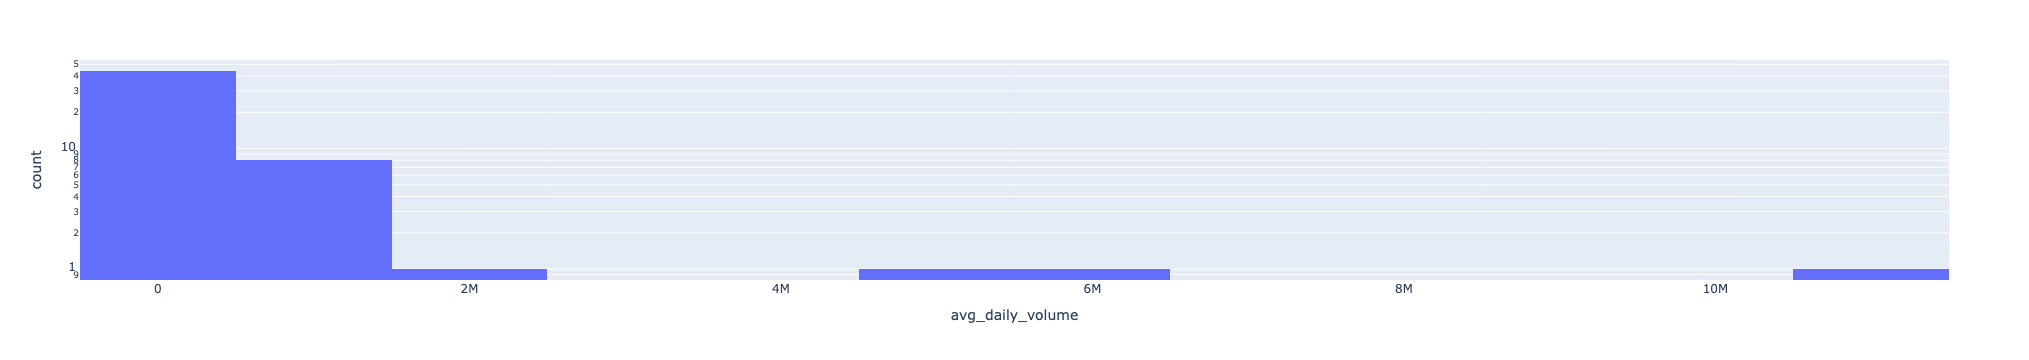

In [38]:
px.histogram(df_mh[['question', 'avg_daily_volume']].groupby('question').mean(), 'avg_daily_volume', log_y=True)

## Example Usage: Load and Inspect Data

In [39]:
# List available markets
markets = list_available_markets()
print(f"Found {len(markets)} markets")
print("\nFirst 10 markets:")
for market in markets[:10]:
    print(f"  - {market}")

Found 59 markets

First 10 markets:
  - arg-gim-tal-2025-10-11-draw
  - caf-mtn-tog-2025-09-05-draw
  - cs2-betera-esports-senza-esports-2025-09-30
  - cs2-onyx-gaming-club-superior-esports-2025-10-01
  - dota2-wildcard-gaming-tailung-mafia-2025-09-24
  - ethereum-up-or-down-september-25-9pm-et
  - fed-decreases-interest-rates-by-25-bps-after-september-2025-meeting
  - fed-decreases-interest-rates-by-50-bps-after-september-2025-meeting
  - fed-increases-interest-rates-by-25-bps-after-september-2025-meeting
  - lol-tesc-vs-edgy-2025-09-22


In [40]:
# Select a market to analyze
# Change this to any market slug from the list above
MARKET_SLUG = "ethereum-up-or-down-september-25-9pm-et"  # Example market
MARKET_SLUG = "fed-increases-interest-rates-by-25-bps-after-september-2025-meeting"
# Get metadata
metadata = get_market_metadata(MARKET_SLUG)
print(f"Question: {metadata['question']}")
print(f"Outcomes: {metadata['outcomes']}")
print(f"Start Date: {metadata['start_date']}")
print(f"End Date: {metadata['end_date']}")
print(f"Volume: ${float(metadata['volume']):,.2f}")
print(f"Category: {metadata['category']}")

Question: Fed increases interest rates by 25+ bps after September 2025 meeting?
Outcomes: ['Yes', 'No']
Start Date: 2025-05-07T21:42:51.906720+00:00
End Date: 2025-09-17T12:00:00+00:00
Volume: $67,002,488.50
Category: Unknown


In [41]:
# Load processed data for modeling (single outcome)
df = load_market_data(MARKET_SLUG, outcome_index=0)

print(f"\nLoaded {len(df)} data points")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nLast few rows:")
print(df.tail())

print(f"\nData summary:")
print(df.describe())


Loaded 19085 data points

First few rows:
                  timestamp   price  days_remaining outcome
0 2025-05-07 23:20:06+00:00  0.1050      132.527708     Yes
1 2025-05-07 23:30:06+00:00  0.0195      132.520764     Yes
2 2025-05-07 23:40:06+00:00  0.0200      132.513819     Yes
3 2025-05-07 23:50:06+00:00  0.0200      132.506875     Yes
4 2025-05-08 00:00:06+00:00  0.0200      132.499931     Yes

Last few rows:
                      timestamp   price  days_remaining outcome
19080 2025-09-17 11:10:15+00:00  0.0005        0.034549     Yes
19081 2025-09-17 11:20:08+00:00  0.0005        0.027685     Yes
19082 2025-09-17 11:30:16+00:00  0.0005        0.020648     Yes
19083 2025-09-17 11:40:10+00:00  0.0005        0.013773     Yes
19084 2025-09-17 11:50:13+00:00  0.0005        0.006794     Yes

Data summary:
              price  days_remaining
count  19085.000000    19085.000000
mean       0.011602       66.263613
std        0.010555       38.258082
min        0.000500        0.006794
25

In [42]:
# Load all outcomes combined
df_all = load_all_outcomes(MARKET_SLUG)

print(f"\nLoaded {len(df_all)} total data points across {df_all['outcome'].nunique()} outcomes")
print(f"\nSample data:")
print(df_all.head(10))

print(f"\nPrice statistics by outcome:")
print(df_all.groupby('outcome')['price'].describe())


Loaded 38170 total data points across 2 outcomes

Sample data:
            timestamp   price  unix_timestamp outcome
0 2025-05-07 23:20:06  0.8950      1746660006      No
1 2025-05-07 23:20:06  0.1050      1746660006     Yes
2 2025-05-07 23:30:06  0.9805      1746660606      No
3 2025-05-07 23:30:06  0.0195      1746660606     Yes
4 2025-05-07 23:40:06  0.9800      1746661206      No
5 2025-05-07 23:40:06  0.0200      1746661206     Yes
6 2025-05-07 23:50:06  0.9800      1746661806      No
7 2025-05-07 23:50:06  0.0200      1746661806     Yes
8 2025-05-08 00:00:06  0.9800      1746662406      No
9 2025-05-08 00:00:06  0.0200      1746662406     Yes

Price statistics by outcome:
           count      mean       std     min     25%     50%     75%     max
outcome                                                                     
No       19085.0  0.988398  0.010555  0.8950  0.9885  0.9925  0.9945  0.9995
Yes      19085.0  0.011602  0.010555  0.0005  0.0055  0.0075  0.0115  0.1050


## Visualization Examples

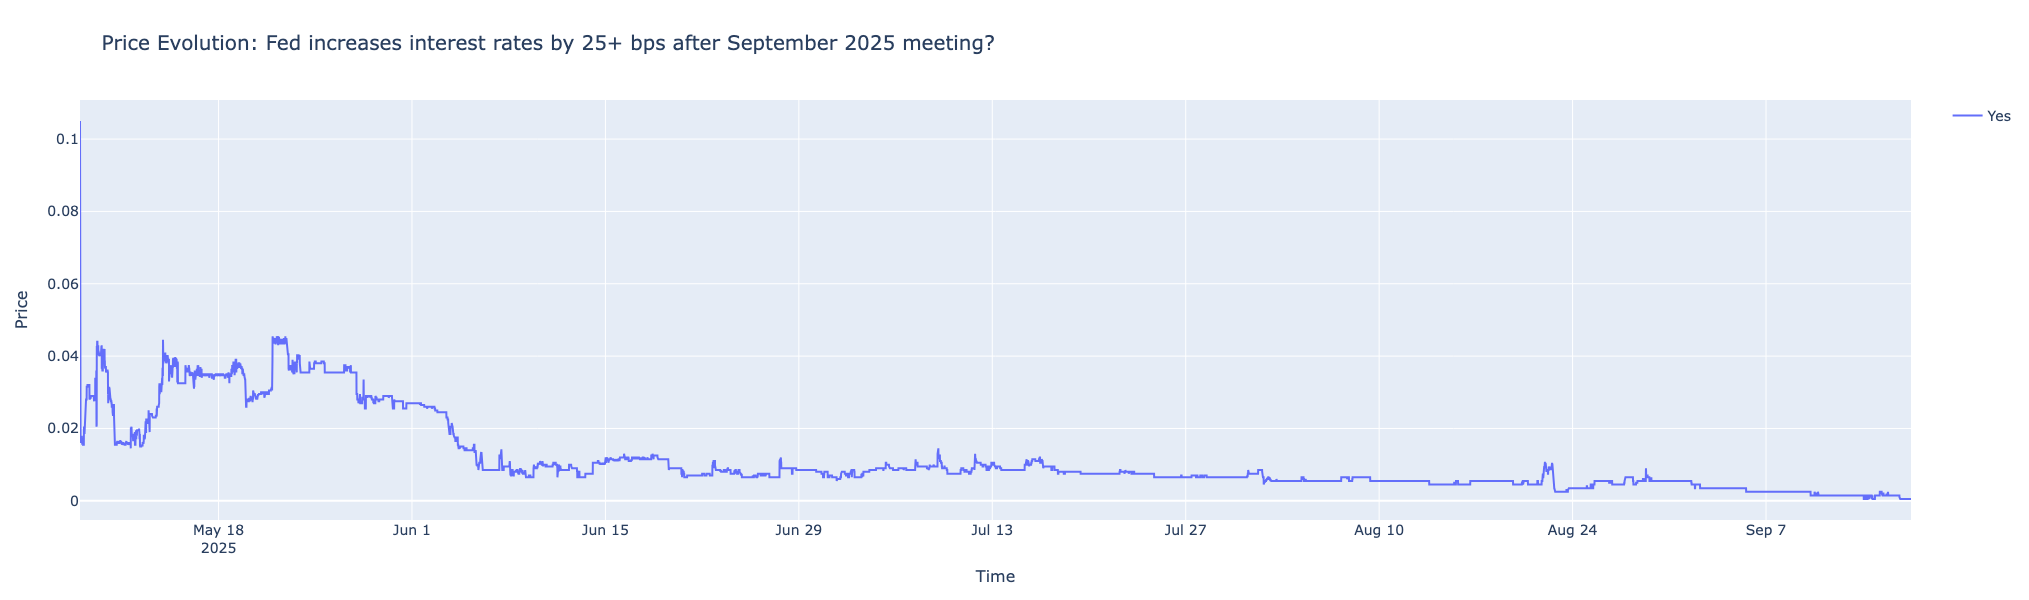

In [43]:
# Plot price evolution over time
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['timestamp'],
    y=df['price'],
    mode='lines',
    name=df['outcome'].iloc[0],
    line=dict(width=2)
))

fig.update_layout(
    title=dict(
        text=f"Price Evolution: {metadata['question']}",
        font=dict(size=20)
    ),
    xaxis_title=dict(text="Time", font=dict(size=16)),
    yaxis_title=dict(text="Price", font=dict(size=16)),
    hovermode='x unified',
    height=600,
    width=1200,
    showlegend=True,
    font=dict(size=14)
)

fig.show()

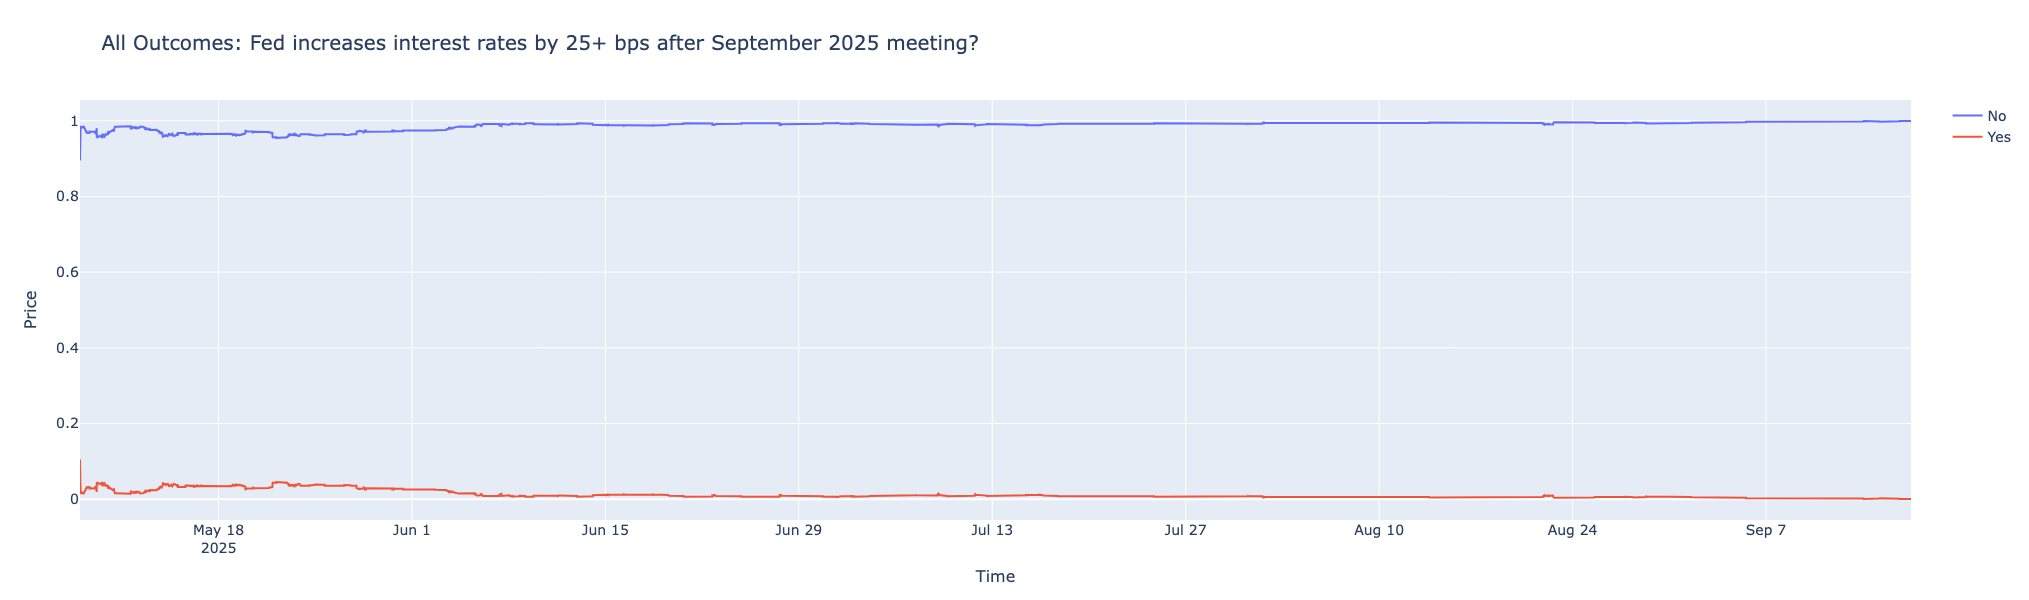

In [44]:
# Plot all outcomes together
fig = go.Figure()

for outcome in df_all['outcome'].unique():
    df_outcome = df_all[df_all['outcome'] == outcome]
    fig.add_trace(go.Scatter(
        x=df_outcome['timestamp'],
        y=df_outcome['price'],
        mode='lines',
        name=outcome,
        line=dict(width=2)
    ))

fig.update_layout(
    title=dict(
        text=f"All Outcomes: {metadata['question']}",
        font=dict(size=20)
    ),
    xaxis_title=dict(text="Time", font=dict(size=16)),
    yaxis_title=dict(text="Price", font=dict(size=16)),
    hovermode='x unified',
    height=600,
    width=1200,
    showlegend=True,
    font=dict(size=14)
)

fig.show()

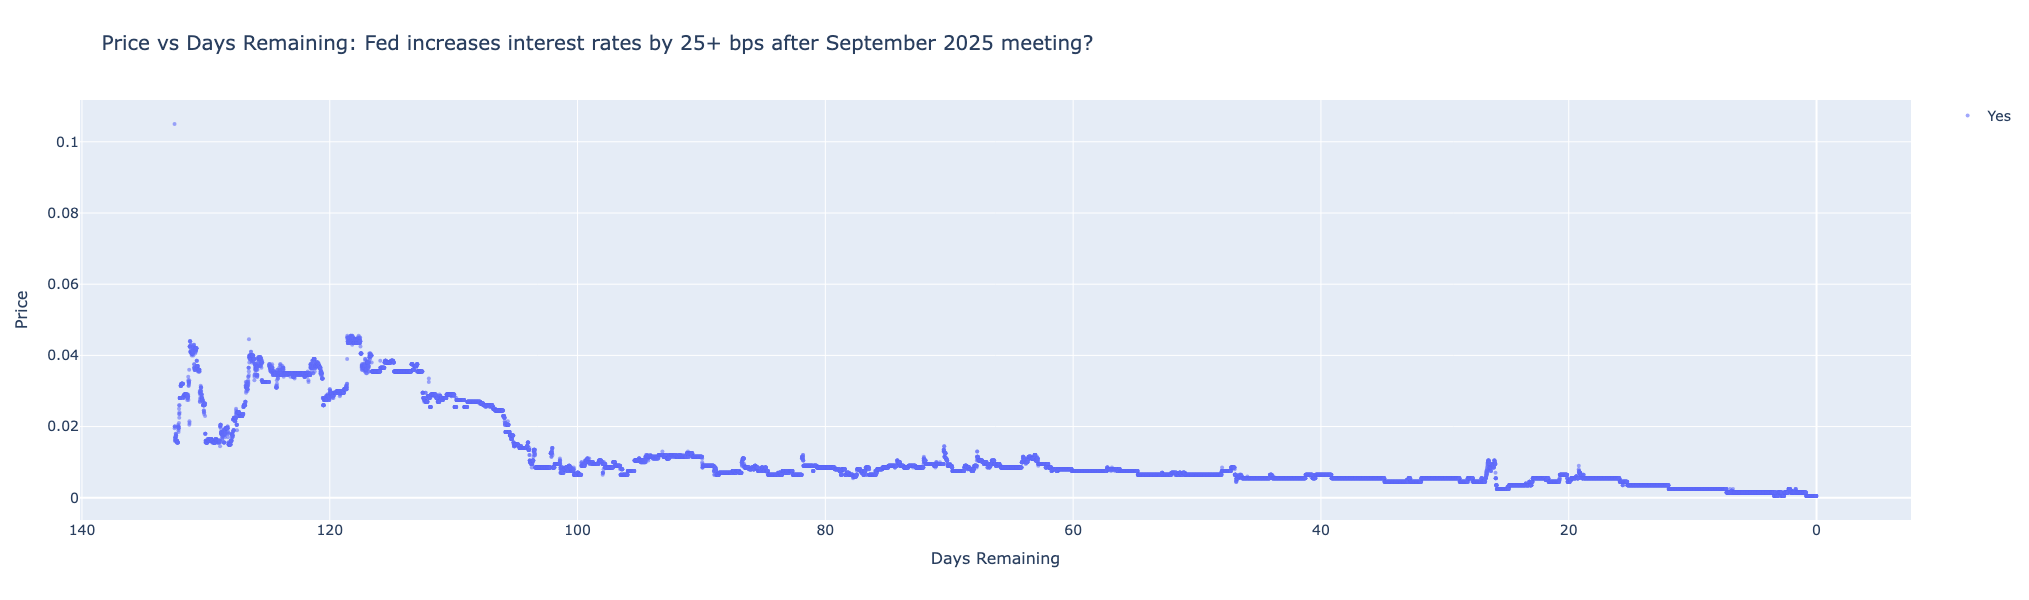

In [45]:
# Plot price vs days remaining (useful for modeling)
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['days_remaining'],
    y=df['price'],
    mode='markers',
    name=df['outcome'].iloc[0],
    marker=dict(size=4, opacity=0.6),
    text=df['timestamp'].dt.strftime('%Y-%m-%d %H:%M'),
    hovertemplate='Days Remaining: %{x:.2f}<br>Price: %{y:.3f}<br>Time: %{text}<extra></extra>'
))

fig.update_layout(
    title=dict(
        text=f"Price vs Days Remaining: {metadata['question']}",
        font=dict(size=20)
    ),
    xaxis_title=dict(text="Days Remaining", font=dict(size=16)),
    yaxis_title=dict(text="Price", font=dict(size=16)),
    height=600,
    width=1200,
    showlegend=True,
    font=dict(size=14)
)

# Reverse x-axis so time flows left to right
fig.update_xaxes(autorange="reversed")

fig.show()

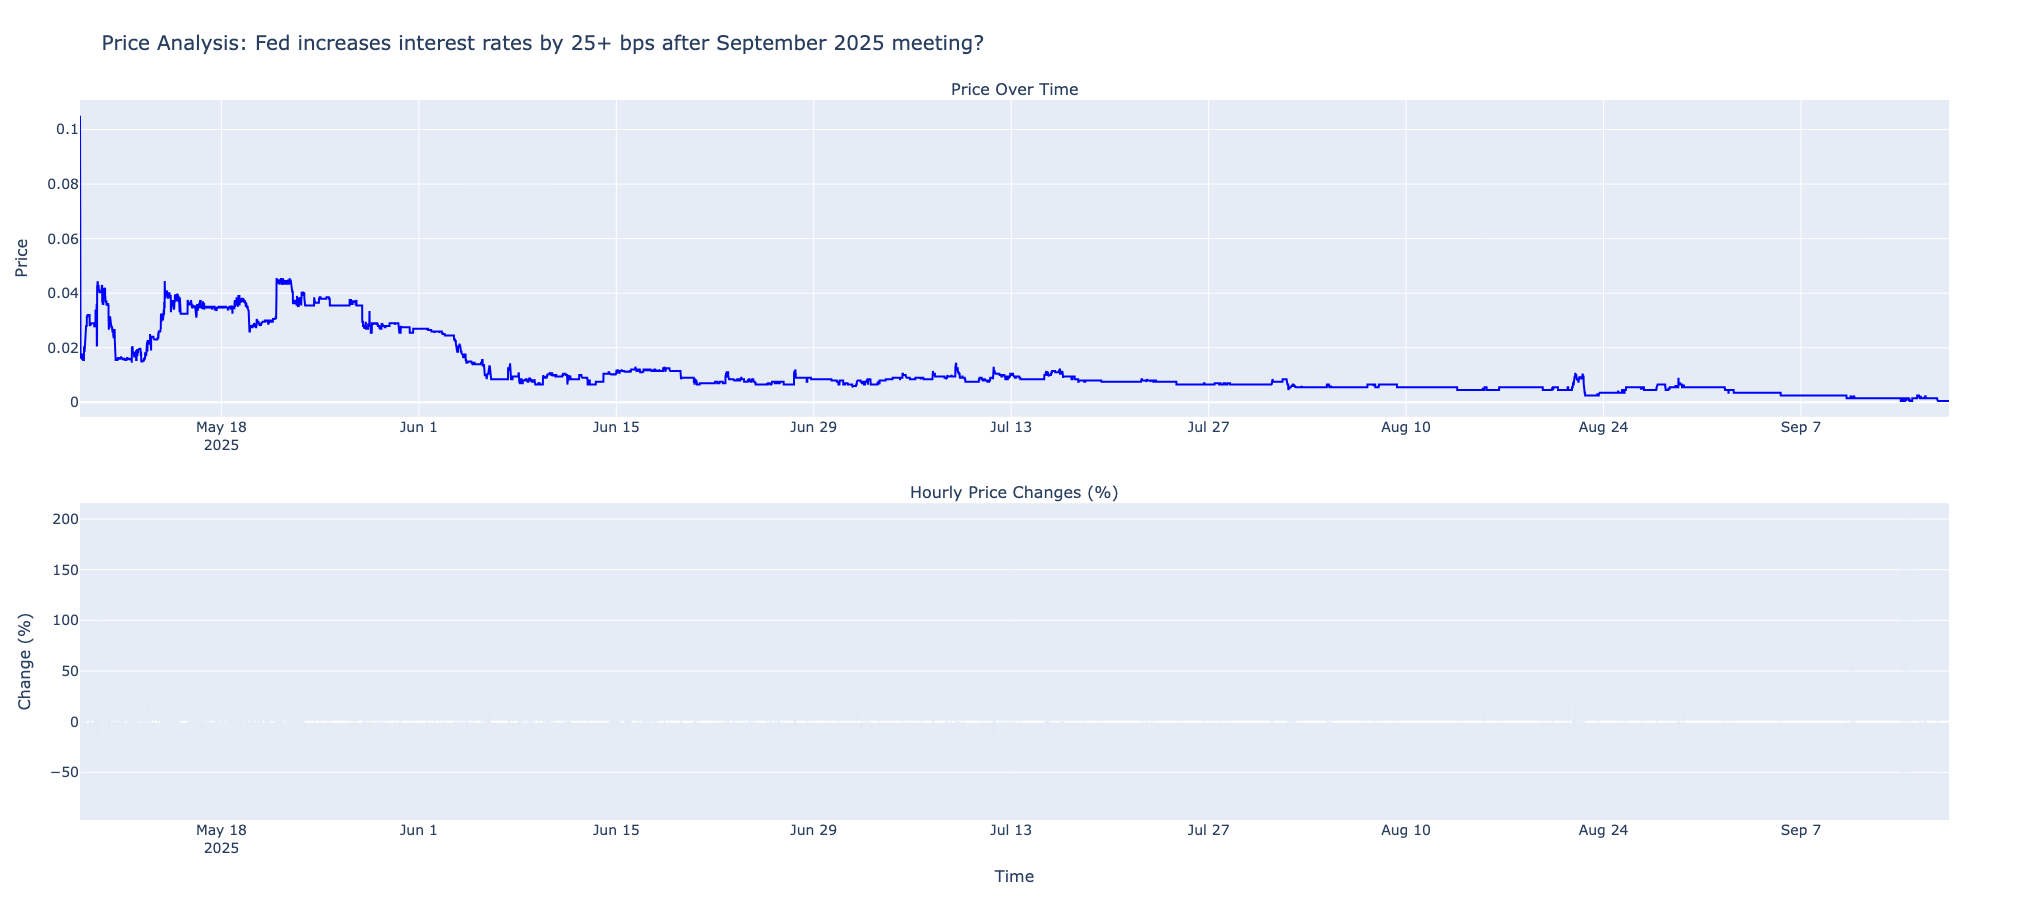

In [16]:
# Compute and plot price changes
df_changes = df.copy()
df_changes['price_change_1h'] = df_changes['price'].diff()
df_changes['price_change_pct'] = df_changes['price'].pct_change() * 100

# Create subplot with price and changes
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=('Price Over Time', 'Hourly Price Changes (%)'),
    vertical_spacing=0.12
)

# Price line
fig.add_trace(
    go.Scatter(
        x=df_changes['timestamp'],
        y=df_changes['price'],
        mode='lines',
        name='Price',
        line=dict(width=2, color='blue')
    ),
    row=1, col=1
)

# Price change bars
colors = ['red' if x < 0 else 'green' for x in df_changes['price_change_pct'].fillna(0)]
fig.add_trace(
    go.Bar(
        x=df_changes['timestamp'],
        y=df_changes['price_change_pct'],
        name='Change %',
        marker_color=colors
    ),
    row=2, col=1
)

fig.update_layout(
    title=dict(
        text=f"Price Analysis: {metadata['question']}",
        font=dict(size=20)
    ),
    height=900,
    width=1200,
    showlegend=False,
    font=dict(size=14)
)

fig.update_xaxes(title_text="Time", row=2, col=1, title_font=dict(size=16))
fig.update_yaxes(title_text="Price", row=1, col=1, title_font=dict(size=16))
fig.update_yaxes(title_text="Change (%)", row=2, col=1, title_font=dict(size=16))

fig.show()

## Feature Engineering Examples

Common features for price prediction models:

In [16]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add common features for price prediction.
    
    Features added:
        - price_change_1: 1-period price change
        - price_change_pct: percentage change
        - rolling_mean_X: rolling average over X periods
        - rolling_std_X: rolling standard deviation
        - momentum_X: price momentum over X periods
        - volatility_X: rolling volatility
    """
    df = df.copy()
    
    # Price changes
    df['price_change_1'] = df['price'].diff()
    df['price_change_pct'] = df['price'].pct_change() * 100
    
    # Rolling features (different windows)
    for window in [5, 10, 20]:
        df[f'rolling_mean_{window}'] = df['price'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['price'].rolling(window=window).std()
        df[f'momentum_{window}'] = df['price'] - df['price'].shift(window)
        df[f'volatility_{window}'] = df['price'].rolling(window=window).std()
    
    # Distance from moving averages
    df['dist_from_ma_5'] = df['price'] - df['rolling_mean_5']
    df['dist_from_ma_20'] = df['price'] - df['rolling_mean_20']
    
    # Time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    
    return df


# Apply feature engineering
df_features = add_features(df)

print("Features added:")
print(df_features.columns.tolist())

print("\nSample with features:")
print(df_features.head(25))

Features added:
['timestamp', 'price', 'days_remaining', 'outcome', 'price_change_1', 'price_change_pct', 'rolling_mean_5', 'rolling_std_5', 'momentum_5', 'volatility_5', 'rolling_mean_10', 'rolling_std_10', 'momentum_10', 'volatility_10', 'rolling_mean_20', 'rolling_std_20', 'momentum_20', 'volatility_20', 'dist_from_ma_5', 'dist_from_ma_20', 'hour', 'day_of_week']

Sample with features:
                   timestamp   price  days_remaining outcome  price_change_1  \
0  2025-05-07 23:20:06+00:00  0.1050      132.527708     Yes             NaN   
1  2025-05-07 23:30:06+00:00  0.0195      132.520764     Yes         -0.0855   
2  2025-05-07 23:40:06+00:00  0.0200      132.513819     Yes          0.0005   
3  2025-05-07 23:50:06+00:00  0.0200      132.506875     Yes          0.0000   
4  2025-05-08 00:00:06+00:00  0.0200      132.499931     Yes          0.0000   
5  2025-05-08 00:10:06+00:00  0.0160      132.492986     Yes         -0.0040   
6  2025-05-08 00:20:06+00:00  0.0160      132.48

## Summary Statistics

In [17]:
# Summary statistics for the market
print(f"Market: {metadata['question']}")
print(f"="*80)
print(f"\nOutcome analyzed: {df['outcome'].iloc[0]}")
print(f"\nData points: {len(df)}")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Duration: {(df['timestamp'].max() - df['timestamp'].min()).total_seconds() / 3600:.1f} hours")

print(f"\nPrice statistics:")
print(f"  Min: {df['price'].min():.4f}")
print(f"  Max: {df['price'].max():.4f}")
print(f"  Mean: {df['price'].mean():.4f}")
print(f"  Std: {df['price'].std():.4f}")
print(f"  Median: {df['price'].median():.4f}")

print(f"\nInitial price: {df['price'].iloc[0]:.4f}")
print(f"Final price: {df['price'].iloc[-1]:.4f}")
print(f"Total change: {df['price'].iloc[-1] - df['price'].iloc[0]:.4f}")
print(f"Percent change: {((df['price'].iloc[-1] / df['price'].iloc[0]) - 1) * 100:.2f}%")

Market: Fed increases interest rates by 25+ bps after September 2025 meeting?

Outcome analyzed: Yes

Data points: 19085
Date range: 2025-05-07 23:20:06+00:00 to 2025-09-17 11:50:13+00:00
Duration: 3180.5 hours

Price statistics:
  Min: 0.0005
  Max: 0.1050
  Mean: 0.0116
  Std: 0.0106
  Median: 0.0075

Initial price: 0.1050
Final price: 0.0005
Total change: -0.1045
Percent change: -99.52%


## Market Calibration Analysis

This section analyzes how well-calibrated Polymarket predictions are by comparing market prices to actual resolutions.

In [46]:
# Import calibration functions from the script
import sys
sys.path.append('../scripts')
from plot_market_calibration import (
    compute_binomial_ci,
    create_calibration_data,
    plot_calibration,
    plot_stratified_calibration,
    print_calibration_statistics
)

# Create calibration data with 100 bins
print("Creating calibration bins...")
n_bins = 100
calibration_df = create_calibration_data(df_mh, n_bins=n_bins)

# Print statistics
print_calibration_statistics(calibration_df)

Creating calibration bins...

=== Calibration Statistics ===

Total observations: 5,138
Number of price bins: 100
Price range: [0.001, 1.000]

Mean Absolute Calibration Error: 0.2234

Top 10 bins by count:
 bin_center  resolution_rate  count
      0.005         0.000000    381
      0.995         1.000000    378
      0.495         0.493464    306
      0.975         1.000000    156
      0.025         0.000000    150
      0.015         0.000000    148
      0.985         1.000000    144
      0.055         0.021127    142
      0.945         0.985714    140
      0.035         0.007812    128

Top 10 bins by calibration error:
 bin_center  resolution_rate  abs_error  count
      0.215         0.913043   0.698043     23
      0.235         0.928571   0.693571     28
      0.805         0.129032   0.675968     31
      0.765         0.090909   0.674091     22
      0.735         0.083333   0.651667     36
      0.145         0.791667   0.646667     48
      0.255         0.900000   0.6

date                 timestamp  price unix_timestamp  \
0     2025-10-06 2025-10-06 17:50:05+00:00  0.690     1759773005   
1     2025-10-07 2025-10-07 00:00:02+00:00  0.690     1759795202   
2     2025-10-08 2025-10-08 00:00:13+00:00  0.675     1759881613   
3     2025-10-09 2025-10-09 00:00:10+00:00  0.665     1759968010   
4     2025-10-10 2025-10-10 00:00:05+00:00  0.665     1760054405   
...          ...                       ...    ...            ...   
5133  2025-09-01 2025-09-01 00:00:02+00:00  0.500     1756684802   
5134  2025-08-29 2025-08-29 14:00:07+00:00  0.500     1756476007   
5135  2025-08-30 2025-08-30 00:00:04+00:00  0.500     1756512004   
5136  2025-08-31 2025-08-31 00:00:09+00:00  0.500     1756598409   
5137  2025-09-01 2025-09-01 00:00:05+00:00  0.500     1756684805   

                                   slug outcome  resolution_price  \
0           arg-gim-tal-2025-10-11-draw      No               1.0   
1           arg-gim-tal-2025-10-11-draw      No               1.0   
2           arg-gim-tal-2025-10-11-draw      No               1.0   
3           arg-gim-tal-2025-10-11-draw      No               1.0   
4           arg-gim-tal-2025-10-11-draw      No               1.0   
...                                 ...     ...               ...   
5133  xrp-up-or-down-september-1-6am-et    Down               1.0   
5134  xrp-up-or-down-september-1-6am-et      Up               0.0   
5135  xrp-up-or-down-september-1-6am-et      Up               0.0   
5136  xrp-up-or-down-september-1-6am-et      Up               0.0   
5137  xrp-up-or-down-september-1-6am-et      Up               0.0   

      days_remaining                                           question  \
0           5.079803  Will Gimnasia y Esgrima de La Plata vs. CA Tal...   
1           4.822894  Will Gimnasia y Esgrima de La Plata vs. CA Tal...   
2           3.822766  Will Gimnasia y Esgrima de La Plata vs. CA Tal...   
3           2.822801  Will Gimnasia y Esgrima de La Plata vs. CA Tal...   
4           1.822859  Will Gimnasia y Esgrima de La Plata vs. CA Tal...   
...              ...                                                ...   
5133        0.458310               XRP Up or Down - September 1, 6AM ET   
5134        2.874919               XRP Up or Down - September 1, 6AM ET   
5135        2.458287               XRP Up or Down - September 1, 6AM ET   
5136        1.458229               XRP Up or Down - September 1, 6AM ET   
5137        0.458275               XRP Up or Down - September 1, 6AM ET   

                       end_date category  closed        volume  liquidity  \
0     2025-10-11T19:45:00+00:00  Unknown    True  11649.160042        0.0   
1     2025-10-11T19:45:00+00:00  Unknown    True  11649.160042        0.0   
2     2025-10-11T19:45:00+00:00  Unknown    True  11649.160042        0.0   
3     2025-10-11T19:45:00+00:00  Unknown    True  11649.160042        0.0   
4     2025-10-11T19:45:00+00:00  Unknown    True  11649.160042        0.0   
...                         ...      ...     ...           ...        ...   
5133  2025-09-01T11:00:00+00:00  Unknown    True  11760.810389        0.0   
5134  2025-09-01T11:00:00+00:00  Unknown    True  11760.810389        0.0   
5135  2025-09-01T11:00:00+00:00  Unknown    True  11760.810389        0.0   
5136  2025-09-01T11:00:00+00:00  Unknown    True  11760.810389        0.0   
5137  2025-09-01T11:00:00+00:00  Unknown    True  11760.810389        0.0   

         volumeNum  liquidityNum  volume24hr  final_price  avg_daily_volume  
0     11649.160042           NaN         NaN          1.0       2736.440456  
1     11649.160042           NaN         NaN          1.0       2736.440456  
2     11649.160042           NaN         NaN          1.0       2736.440456  
3     11649.160042           NaN         NaN          1.0       2736.440456  
4     11649.160042           NaN         NaN          1.0       2736.440456  
...            ...           ...         ...          ...               

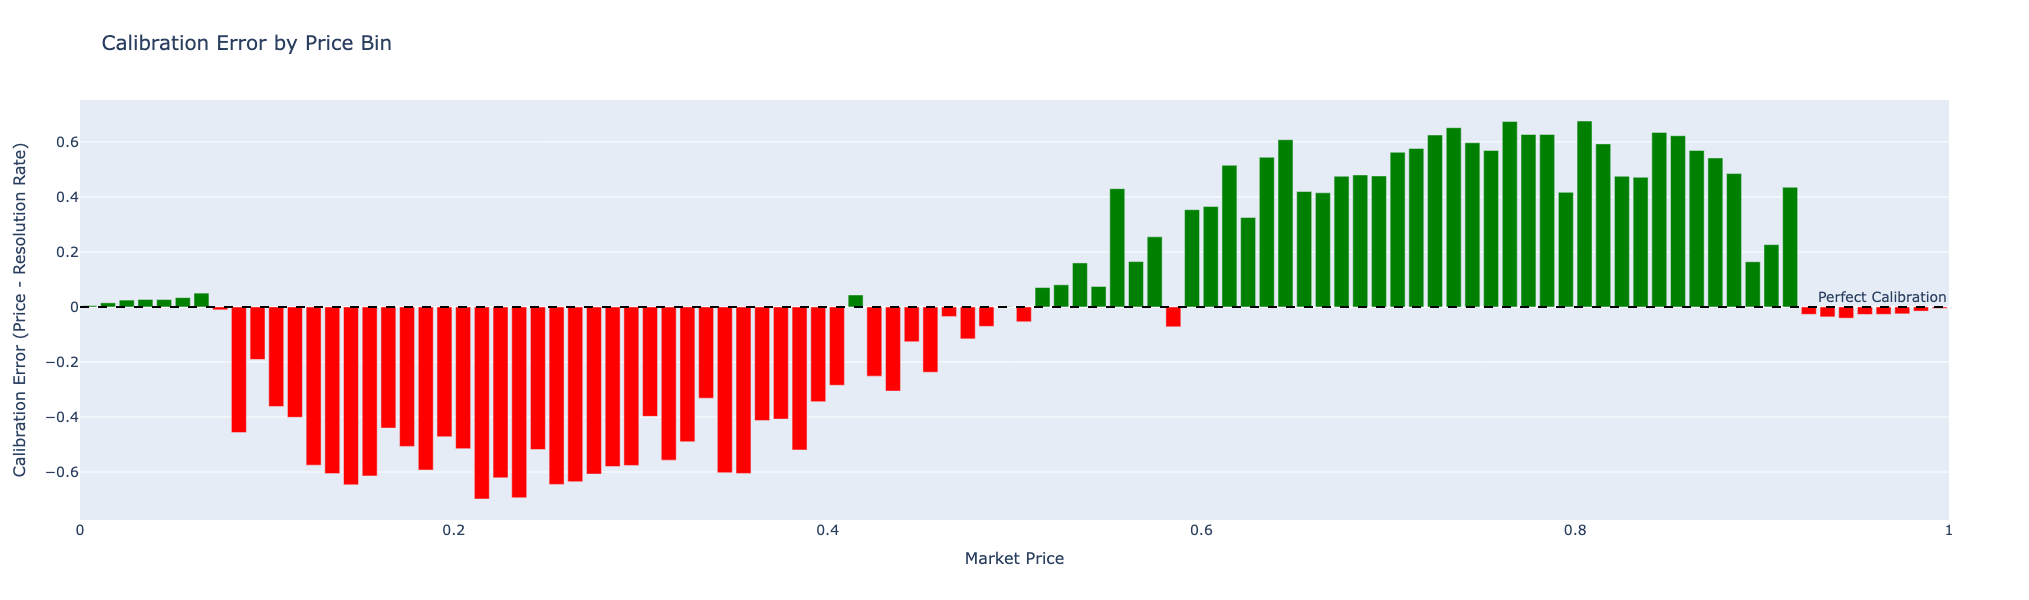

In [47]:
# Plot calibration error by bin
calibration_df['calibration_error'] = calibration_df['bin_center'] - calibration_df['resolution_rate']

fig = go.Figure()

# Add bars for calibration error
colors = ['red' if x < 0 else 'green' for x in calibration_df['calibration_error']]
fig.add_trace(go.Bar(
    x=calibration_df['bin_center'],
    y=calibration_df['calibration_error'],
    marker_color=colors,
    name='Calibration Error',
    hovertemplate='Price: %{x:.3f}<br>Error: %{y:.3f}<extra></extra>'
))

# Add zero line
fig.add_hline(y=0, line_dash="dash", line_color="black", annotation_text="Perfect Calibration")

fig.update_layout(
    title=dict(text="Calibration Error by Price Bin", font=dict(size=20)),
    xaxis_title=dict(text="Market Price", font=dict(size=16)),
    yaxis_title=dict(text="Calibration Error (Price - Resolution Rate)", font=dict(size=16)),
    height=600,
    width=1200,
    font=dict(size=14),
    showlegend=False
)

fig.show()

In [48]:
# Explore the calibration data
print("Calibration DataFrame:")
print(calibration_df.head(10))
print("\n" + "="*80 + "\n")

# Show bins with most observations
print("Top 10 bins by observation count:")
top_bins = calibration_df.nlargest(10, 'count')[['bin_center', 'resolution_rate', 'count', 'ci_lower', 'ci_upper']]
print(top_bins.to_string(index=False))

Calibration DataFrame:
   bin_center  bin_min  bin_max  resolution_rate  count      ci_lower  \
0       0.005   0.0005     0.01         0.000000    381  0.000000e+00   
1       0.015   0.0105     0.02         0.000000    148  0.000000e+00   
2       0.025   0.0205     0.03         0.000000    150  1.734723e-18   
3       0.035   0.0305     0.04         0.007812    128  1.380432e-03   
4       0.045   0.0405     0.05         0.018018    111  4.955179e-03   
5       0.055   0.0505     0.06         0.021127    142  7.210620e-03   
6       0.065   0.0605     0.07         0.014706     68  2.600684e-03   
7       0.075   0.0705     0.08         0.085366     82  4.196652e-02   
8       0.085   0.0805     0.09         0.541667     24  3.507487e-01   
9       0.095   0.0915     0.10         0.285714     28  1.525400e-01   

   ci_upper  abs_error  calibration_error  
0  0.009982   0.005000           0.005000  
1  0.025299   0.015000           0.015000  
2  0.024970   0.025000           0.025000

## Interpretation

A **well-calibrated market** should show points along the diagonal red line. This means:
- When markets are priced at 20%, they should resolve to 1 about 20% of the time
- When markets are priced at 80%, they should resolve to 1 about 80% of the time

**Key observations from the plot:**
- The shaded blue area shows 95% confidence intervals
- Marker size indicates the number of observations in each bin
- The color gradient shows observation density
- Most data concentrates at the extremes (near 0 and 1)
- The Mean Absolute Calibration Error (MACE) quantifies overall calibration quality

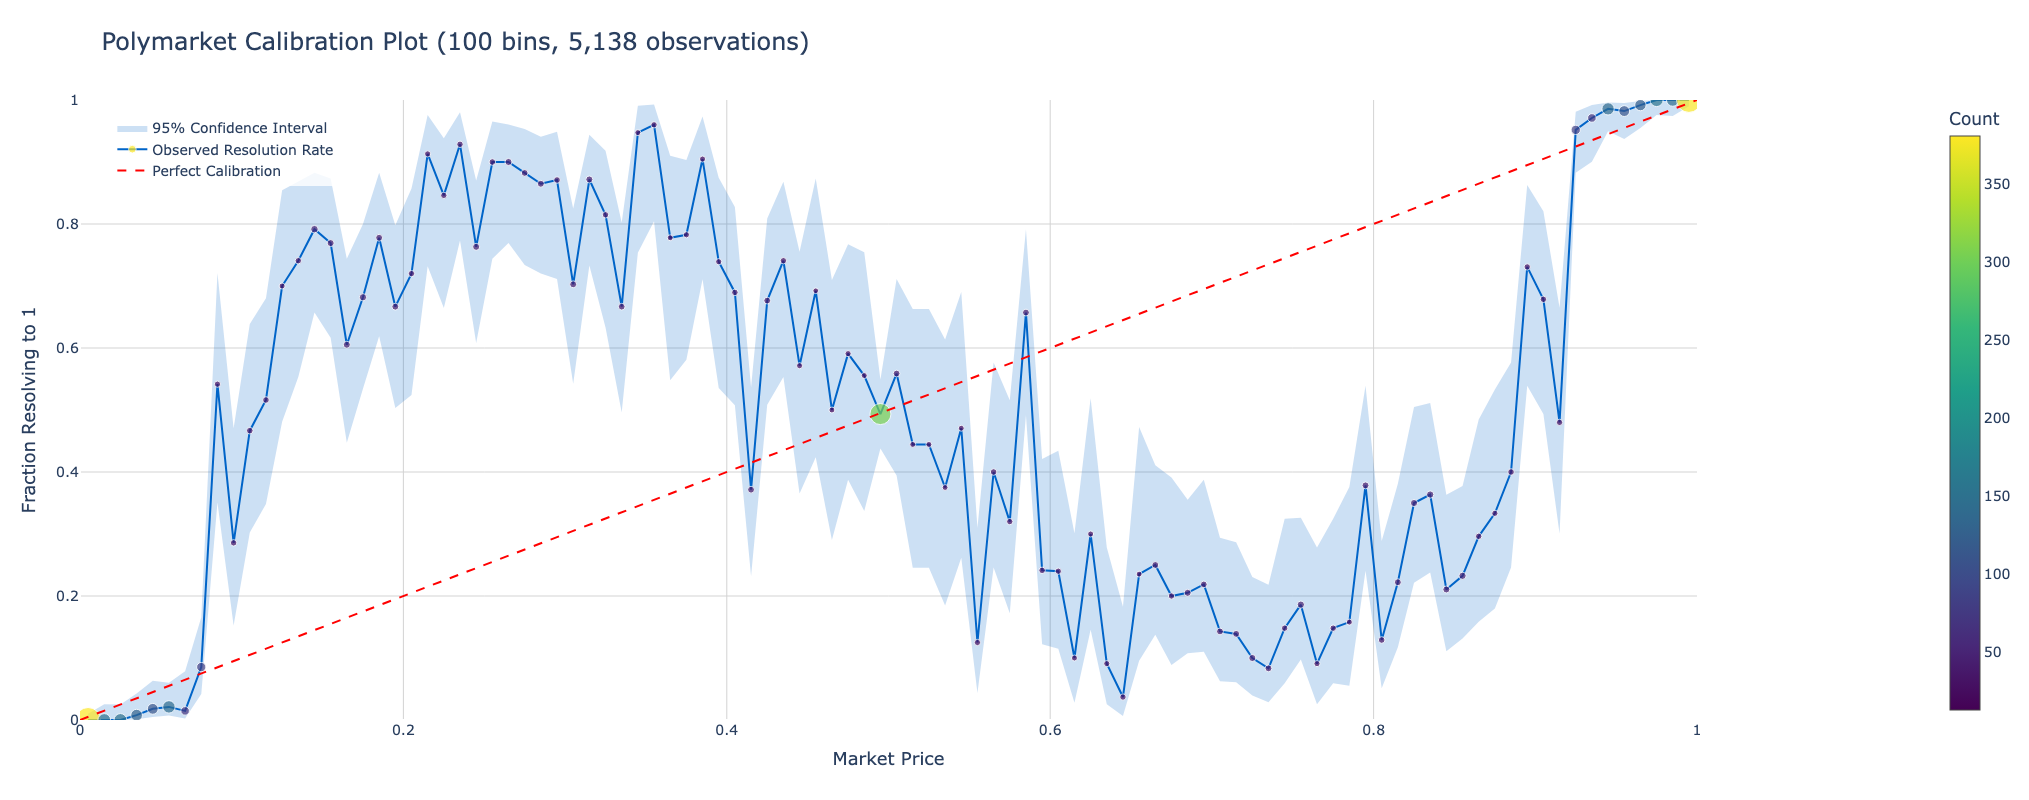

In [49]:
# Create and display the calibration plot
fig = plot_calibration(
    calibration_df, 
    title=f"Polymarket Calibration Plot ({n_bins} bins, {len(df_mh):,} observations)"
)
fig.show()

## Stratified Calibration Analysis

This section analyzes calibration stratified by market characteristics (e.g., trading volume).

## Interpretation: Stratified Calibration

The **stratified calibration plot** shows how calibration varies across different volume quantiles:

- **Each line** represents a volume quantile (Q1 = lowest volume, Q4 = highest volume)
- **Different colors** distinguish the quantiles
- **The diagonal black dashed line** represents perfect calibration
- **Deviation from the diagonal** indicates calibration issues

**Key insights to look for:**
- Do higher-volume markets show better calibration?
- Are there systematic differences in calibration quality across volume levels?
- Do low-volume markets tend to over/underestimate probabilities?

**Expected patterns:**
- Higher volume markets (Q4) might show better calibration due to more active price discovery
- Lower volume markets (Q1) might show noisier calibration with more deviation from the diagonal

In [24]:
# Create stratified calibration data by average daily volume (4 quantiles)
# reload(plot_market_calibration.create_calibration_data)
print("Creating stratified calibration data by avg_daily_volume...")
stratified_df = create_calibration_data(
    df_mh, 
    n_bins=100, 
    cut_by='avg_daily_volume', 
    cut_bins=4
)

print(f"\nCreated {len(stratified_df)} calibration points across {stratified_df['avg_daily_volume_quantile'].nunique()} volume quantiles")
print("\nSample of stratified data:")
print(stratified_df.head(10))

Creating stratified calibration data by avg_daily_volume...

Created 386 calibration points across 4 volume quantiles

Sample of stratified data:
   bin_center  bin_min  bin_max  resolution_rate  count      ci_lower  \
0       0.005   0.0005   0.0080              0.0     39  0.000000e+00   
1       0.015   0.0105   0.0200              0.0      5  0.000000e+00   
2       0.025   0.0205   0.0295              0.0     16  0.000000e+00   
3       0.035   0.0335   0.0400              0.0     12  2.775558e-17   
4       0.045   0.0425   0.0435              0.0      3  5.551115e-17   
5       0.055   0.0530   0.0600              0.0      6  2.775558e-17   
6       0.065   0.0645   0.0695              0.0      5  0.000000e+00   
7       0.075   0.0715   0.0785              0.0     16  0.000000e+00   
8       0.085   0.0805   0.0805              0.0      1  0.000000e+00   
9       0.095   0.0915   0.1000              0.0      8  0.000000e+00   

   ci_upper avg_daily_volume_quantile avg_daily_vo

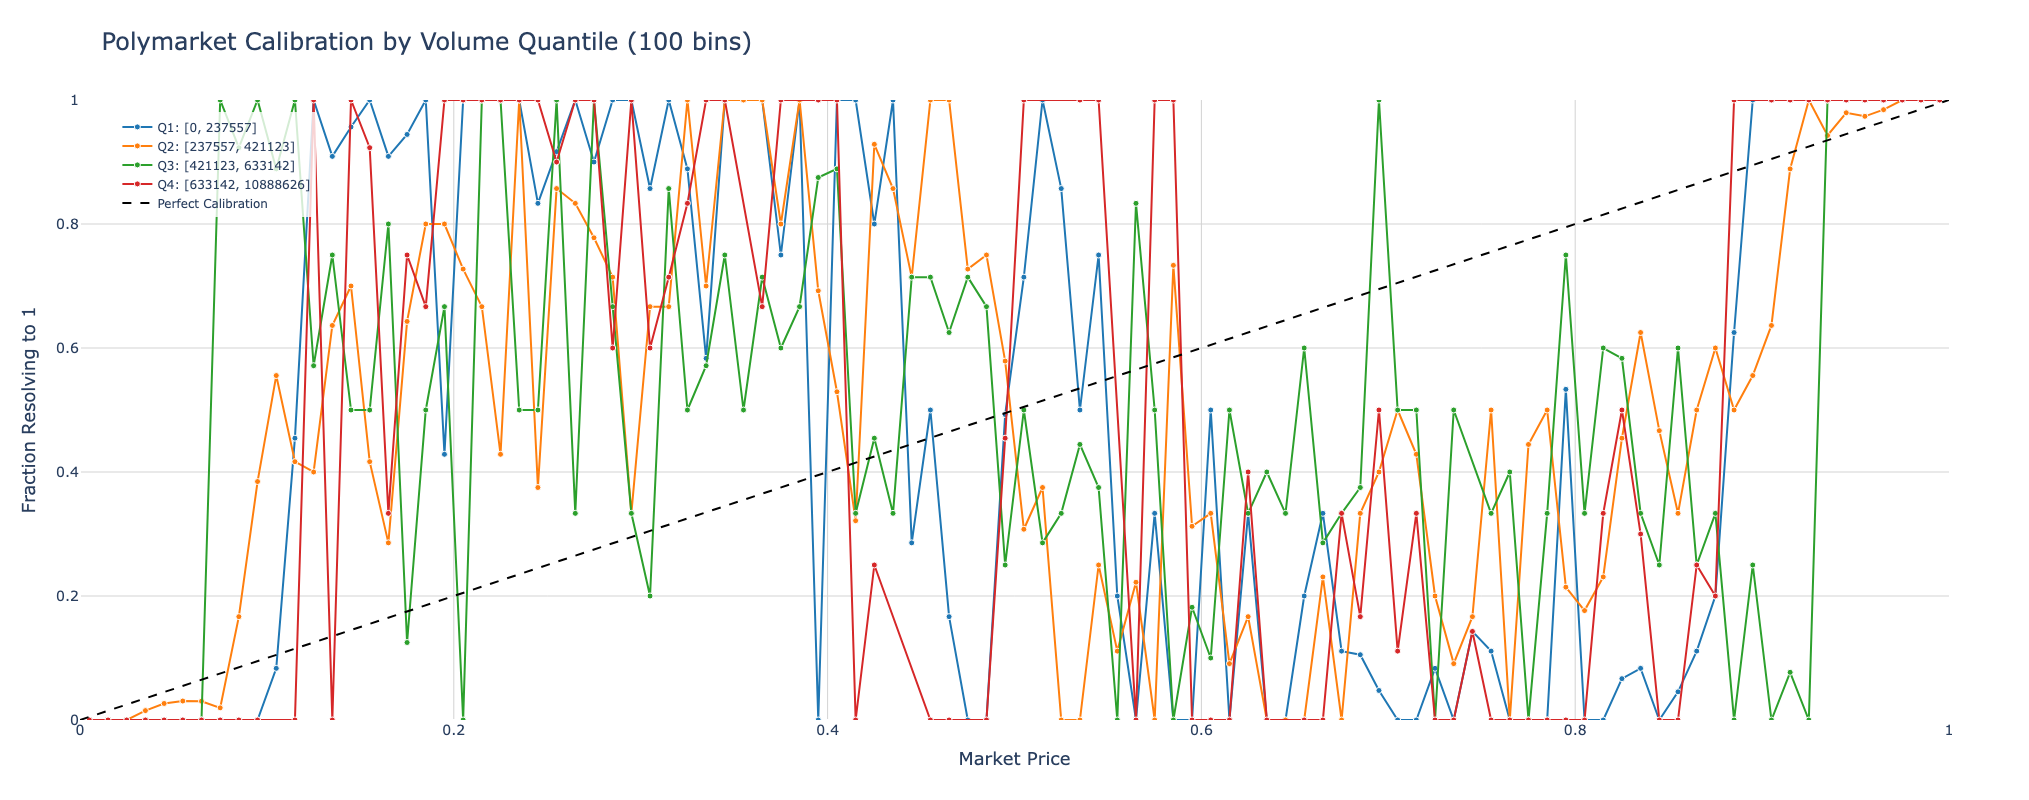

In [25]:
# Create stratified calibration plot
fig = plot_stratified_calibration(
    stratified_df,
    cut_by='avg_daily_volume',
    title=f"Polymarket Calibration by Volume Quantile ({n_bins} bins)"
)
fig.show()

In [26]:
# Examine the volume quantiles
print("Volume quantile statistics:")
for quantile in sorted(stratified_df['avg_daily_volume_quantile'].unique()):
    quantile_data = stratified_df[stratified_df['avg_daily_volume_quantile'] == quantile]
    vol_range = quantile_data['avg_daily_volume_range'].iloc[0]
    n_obs = quantile_data['count'].sum()
    print(f"  {quantile} {vol_range}: {n_obs:,} observations")

Volume quantile statistics:
  Q1 [0, 237557]: 1,340 observations
  Q2 [237557, 421123]: 1,464 observations
  Q3 [421123, 633142]: 1,208 observations
  Q4 [633142, 10888626]: 1,126 observations


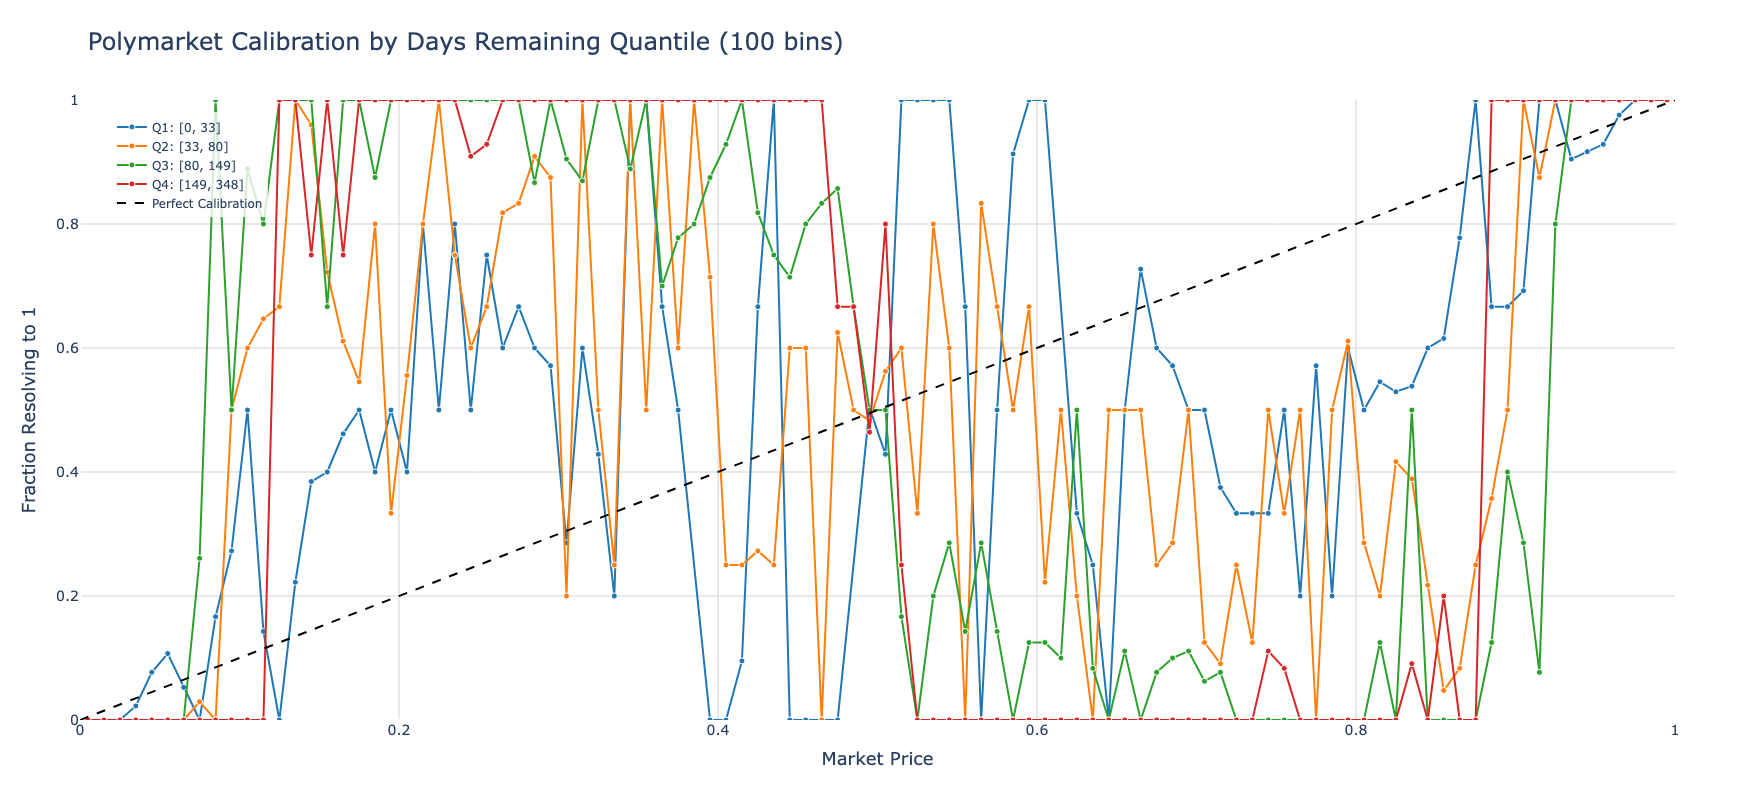

In [31]:
# Create stratified calibration plot
field = 'days_remaining'
stratified_df = create_calibration_data(
    df_mh, 
    n_bins=100, 
    cut_by=field, 
    cut_bins=4
)


fig = plot_stratified_calibration(
    stratified_df,
    cut_by=field,
    title=f"Polymarket Calibration by Days Remaining Quantile ({n_bins} bins)"
)
fig.show()